In [1]:
# Setup

import mujoco

import numpy as np
import mediapy as media
import mujoco.viewer as viewer

# Load the model and create a data object
def get_model():
    xml = "panda.xml"
    return mujoco.MjModel.from_xml_path(xml)
def get_data(model):
    return mujoco.MjData(model)

model = get_model()
data = get_data(model)
renderer = mujoco.Renderer(model)


camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.5

In [2]:
def generate_random_joint_angles(model):
    joint_ranges = model.jnt_range
    joint_angles = []
    for i, (min_range, max_range) in enumerate(joint_ranges):
        # print(f"Joint {i}: [{min_range}, {max_range}]")
        joint_angles.append(np.random.uniform(min_range, max_range))
    return joint_angles

def forward(model, data, camera):
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera)

In [4]:
def quaternion_to_rpy(quat):
    """
    Converts a quaternion to roll, pitch, yaw (RPY) angles for any specified Euler angle sequence.
    
    Args:
        quat (np.array): Quaternion [w, x, y, z]
        seq (str): Euler angle sequence ("zyx", "zxy", "xyz", etc.)
        
    Returns:
        np.array: Roll, pitch, and yaw angles in radians.
    """
    w, y, z, x = quat

    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(np.clip(2 * (w * y - z * x), -1.0, 1.0))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
  
    return np.array([roll, pitch, yaw])

In [4]:
def ik_solver(model, data, end_effector_name, goal_pos, goal_ori, max_iters=1000, step_size=0.5, tol=1e-3, damping=0.1, alpha=0.5):
    """
    Inverse Kinematics solver for MuJoCo using Jacobian-based optimization.
    
    Args:
        model (MjModel): MuJoCo model.
        data (MjData): MuJoCo simulation data.
        end_effector_name (str): Name of the end-effector body.
        goal_pos (np.array): Desired (x, y, z) position of the end-effector.
        max_iters (int): Maximum number of iterations for IK.
        tol (float): Tolerance for positional error.
        damping (float): Damping factor for regularization in the Jacobian inverse.
        
    Returns:
        np.array: Joint positions (`qpos`) that achieve the goal position.
    """
    # Get the end-effector body ID
    end_effector_id = model.body(end_effector_name).id
    
    # Initialize Jacobian
    jacp = np.zeros((3, model.nv))  # Translational Jacobian
    jacr = np.zeros((3, model.nv)) #rotational jacobian
    qvel = np.zeros(model.nv)  # To store computed joint velocities
    # Iteratively solve for joint positions
    for iteration in range(max_iters):
        # Compute the current end-effector position
        current_pos = data.xpos[end_effector_id]
        current_ori_quat = data.xquat[end_effector_id]  # Orientation as quaternion
        current_ori = quaternion_to_rpy(current_ori_quat)

        # test if the orientation is correct
        # print(f"current_ori_quat: {current_ori_quat}")
        quat = np.zeros((4, 1), dtype=np.float64)
        euler = np.array(current_ori).reshape(3, 1)
        mujoco.mju_euler2Quat(quat, euler, "ZXY")
        # print(f"quat: {quat.flatten()}")
        # assert np.allclose(np.absolute(quat.flatten()), np.absolute(current_ori_quat))

        # Calculate the positional error
        error = goal_pos - current_pos
        ori_error = goal_ori - current_ori
    
        error = np.hstack((error, ori_error))
        error_norm = np.linalg.norm(error)
        if error_norm < tol:
            print("IK converged!")
            return data.qpos.copy(), qvel
        # mujoco.mj_jac(model, data, jacp, None, goal_pos, end_effector_id)
        # J = jacp

        mujoco.mj_jac(model, data, jacp, jacr, goal_pos, end_effector_id)
        J = np.vstack((jacp, jacr))


        cartesian_velocity = alpha * error
        n = J.shape[1]
        I = np.identity(n)
        product = J.T @ J + damping * I

        
        if np.isclose(np.linalg.det(product), 0):
            j_inv = np.linalg.pinv(product) @ J.T
        else:
            j_inv = np.linalg.inv(product) @ J.T
        
        # qvel = j_inv @ cartesian_velocity
        delta_q = j_inv @ error
        #compute next step
        data.qpos += step_size * delta_q

        for i in range(model.nq):
            data.qpos[i] = np.clip(data.qpos[i], model.jnt_range[i][0], model.jnt_range[i][1])
        
        # Recompute the simulation state
        mujoco.mj_forward(model, data)
    
    print("IK did not converge within the maximum number of iterations.")
    return data.qpos.copy(), qvel

In [96]:
# ik solver based on roboitcs-toolbox
import roboticstoolbox as rtb
from spatialmath import SE3
import numpy as np

# Load the Panda robot model
panda = rtb.models.Panda()

qpos = generate_random_joint_angles(model)
qpos = qpos[:7]

Tep = panda.fkine(qpos)
print(Tep)
print("Position", Tep.t) # shape 3x1
print("Orientation", Tep.rpy(unit='deg')) # shape 3x1

print("Rotation Matrix", Tep.R) # shape 3x3
print("Quaternion", Tep.A) # shape 4x1
sol = panda.ikine_LM(Tep)

# Check if a solution was found
if sol.success:
    print("IK Solution found!")
    print(sol)
# Forward kinematics to verify the solution
eef_pose = panda.fkine(sol.q)
target_pose = panda.fkine(qpos)
print("End-Effector Pose from FK:\n", eef_pose)
print("Target Pose:\n", target_pose)


   0.8889   -0.1789   -0.4217    0.1391    
  -0.4107    0.0963   -0.9067   -0.5078    
   0.2028    0.9791    0.01212   0.2982    
   0         0         0         1         

Position [ 0.13912797 -0.50782333  0.29822636]
Orientation [ 89.29103188 -11.70155482 -24.79966695]
Rotation Matrix [[ 0.88891381 -0.17890623 -0.42169279]
 [-0.41072957  0.09629554 -0.90665781]
 [ 0.20281387  0.97914234  0.01211636]]
Quaternion [[ 0.88891381 -0.17890623 -0.42169279  0.13912797]
 [-0.41072957  0.09629554 -0.90665781 -0.50782333]
 [ 0.20281387  0.97914234  0.01211636  0.29822636]
 [ 0.          0.          0.          1.        ]]
IK Solution found!
IKSolution: q=[0.5554, 0.6015, -1.613, -2.54, -1.878, 2.358, 2.264], success=True, iterations=13, searches=2, residual=3.41e-08
End-Effector Pose from FK:
    0.8889   -0.1789   -0.4217    0.1391    
  -0.4107    0.0963   -0.9067   -0.5078    
   0.2028    0.9791    0.01212   0.2982    
   0         0         0         1         

Target Pose:
    0.88

[0.         0.92387954 0.38268342 0.        ]
initial qpos => [0. 0. 0. 0. 0. 0. 0. 0. 0.]
initial xpos => [0.088 0.    0.926]
initial rpy => [2.35619453 0.         3.14159265] 

target qpos => [-0.37391984 -1.55893124 -0.91068923 -0.09218324  2.63495763  2.37818382
  2.13962287  0.02075158  0.00291257]
target xpos => [-0.79587979  0.28221148  0.37113845]
target rpy => [ 0.03477487 -1.05240639 -1.68027491] 

achieved qpos => [ 2.44662566  1.22780073  0.97233628 -0.80181641 -2.50645537  2.13929982
  2.43677717  0.          0.        ]
achieved xpos => [-0.7958796   0.28221152  0.3711383 ]
achieved_rpy => [ 0.03477465 -1.05240654 -1.68027492] 



Initial,Target,Achieved

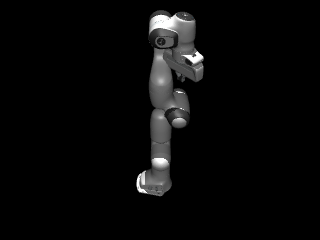
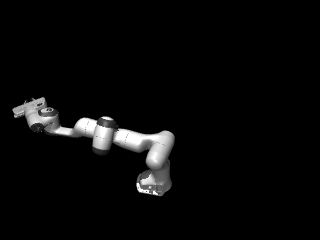
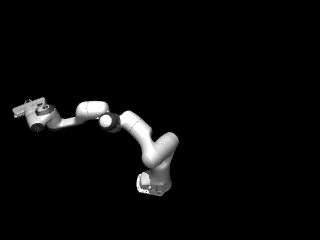

In [112]:
# Test a forward pass and a the ik solver to ensure it works
# Specifically, generate a random joint angle, get the eef pos of that joint angle, then use the ik solver to get the joint angles that will get the eef to the same position
# Ideally the joint angles should be the same as the random joint angles
# Therefore, this test assumes the target eef pos is achievable by the robot

# Generate a random joint angle as target
qpos = generate_random_joint_angles(model) # qpos is world position
target_qpos = qpos.copy()

mujoco.mj_forward(model, data)

# Initial position
mujoco.mj_resetDataKeyframe(model, data, 1)
forward(model, data, camera)
init_plot = renderer.render()
init_xpos = data.body('hand').xpos.copy()
print(data.body('hand').xquat.copy())
init_rpy =quaternion_to_rpy(data.body('hand').xquat.copy())
print("initial qpos =>", data.qpos.copy())
print("initial xpos =>", init_xpos)
print("initial rpy =>", init_rpy, "\n")

# Desired end effector position
data.qpos = target_qpos
forward(model, data, camera)
target_plot = renderer.render()
target_xpos = data.body('hand').xpos.copy()
target_rpy = quaternion_to_rpy(data.body('hand').xquat.copy())
print("target qpos =>", data.qpos.copy())
print("target xpos =>", target_xpos)
print("target rpy =>", target_rpy, "\n")

# Achieved end effector position
mujoco.mj_resetDataKeyframe(model, data, 1)
forward(model, data, camera)
# qpos1, qvel = ik_solver(model, data, "hand", target_xpos, target_rpy, max_iters=10000, step_size=1, tol=1e-3, damping=0.15, alpha=0.5)
Tep = panda.fkine(qpos)
qpos1 = panda.ikine_LM(Tep).q
# add two 0 to qpos1 to make it 9
qpos1 = np.append(qpos1, [0, 0])
data.qpos = qpos1
forward(model, data, camera)
achieved_plot = renderer.render()
achieved_xpos = data.body('hand').xpos.copy()
achived_rpy =quaternion_to_rpy(data.body('hand').xquat.copy())
print("achieved qpos =>", data.qpos.copy())
print("achieved xpos =>", achieved_xpos)
print("achieved_rpy =>", achived_rpy, "\n")

# Plot results
images = {
    "Initial": init_plot,
    "Target": target_plot,
    "Achieved": achieved_plot
}
media.show_images(images)



In [6]:
def generate_random_eef_xpos(count=10):
    # Modify the workspace bounds as needed for your robot
    workspace_bounds = {
        "x": (-0.8, 0.8),
        "y": (-0.8, 0.8),
        "z": (0.1, 1.0),
    }

    goals = []
    for _ in range(count):
        x = np.random.uniform(*workspace_bounds["x"])
        y = np.random.uniform(*workspace_bounds["y"])
        z = np.random.uniform(*workspace_bounds["z"])
        goals.append(np.array([x, y, z]))
    return goals

def generate_random_eef_ori(count = 10):
    ori_goals = []
    for _ in range(count):
        roll = np.random.uniform(-np.pi, np.pi)
        pitch = np.random.uniform(-np.pi, np.pi)
        yaw = np.random.uniform(-np.pi, np.pi)
        ori_goals.append(np.array([roll, pitch, yaw]))
    return ori_goals

end_effector_name = "hand"
num_tests = 10
tol = 1e-3

goals = generate_random_eef_xpos(count=num_tests)
ori_goals = generate_random_eef_ori(count=num_tests)
success_count = 0

for i, (goal, ori_goal) in enumerate(zip(goals, ori_goals)):
    print(f"Test {i + 1}: Goal Position = {goal}, Goal Orientation = {ori_goal}")
    ori_goal = [-1.73104446,  0.00466333,  0.11100802]

    # Reset the simulation state
    mujoco.mj_resetDataKeyframe(model, data, 1)

    # Solve IK
    result_qpos = ik_solver(model, data, end_effector_name, goal, ori_goal, max_iters=1000, step_size=0.5, tol=tol, damping=0.1, alpha=0.5)
    achieved_xpos = data.body('hand').xpos.copy()

    # Calculate error
    error = np.linalg.norm(goal - achieved_xpos)
    print(f"  Achieved Position = {achieved_xpos}, Error = {error:.6f}")

    # Check if within tolerance
    if error <= tol:
        print("  Result: Success")
        success_count += 1
    else:
        print("  Result: Failure")

# Print summary
print(f"\nTotal Tests: {num_tests}")
print(f"Successful Tests: {success_count}")
print(f"Failed Tests: {num_tests - success_count}")



Test 1: Goal Position = [0.78342965 0.44282167 0.73098377], Goal Orientation = [0.37903107 0.93313581 2.18958009]


IK did not converge within the maximum number of iterations.
  Achieved Position = [0.54352671 0.33409925 0.62141409], Error = 0.285271
  Result: Failure
Test 2: Goal Position = [0.09689054 0.36540723 0.89654317], Goal Orientation = [ 2.13361948 -1.52600314 -2.2389846 ]
IK did not converge within the maximum number of iterations.
  Achieved Position = [-0.00277036  0.31731621  0.75846262], Error = 0.176950
  Result: Failure
Test 3: Goal Position = [-0.31787742 -0.31709037  0.70386155], Goal Orientation = [-1.00225359  2.07451231 -1.04318137]
IK did not converge within the maximum number of iterations.
  Achieved Position = [-0.37087285 -0.18673483  0.75449852], Error = 0.149550
  Result: Failure
Test 4: Goal Position = [ 0.44129478 -0.46841921  0.47251571], Goal Orientation = [-0.35014899 -0.73030837 -1.55071599]
IK did not converge within the maximum number of iterations.
  Achieved Position = [0.20590459 0.59547744 0.43042009], Error = 1.090439
  Result: Failure
Test 5: Goal Position